Install Libs

In [2]:
!pip install wandb --upgrade
!pip install pytorch-lightning
!pip install albumentations
!pip install python-dotenv
!pip install torchmetrics

Download Dataset

In [3]:
# https://drive.google.com/file/d//view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JxAktCLpRkUC3Ylc736YsxwTQRTeIRnD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JxAktCLpRkUC3Ylc736YsxwTQRTeIRnD" -O "download.tar.gz" && rm -rf /tmp/cookies.txt
!tar -xvf download.tar.gz

--2021-05-04 12:51:32--  https://docs.google.com/uc?export=download&confirm=AEIj&id=1JxAktCLpRkUC3Ylc736YsxwTQRTeIRnD
Resolving docs.google.com (docs.google.com)... 173.194.79.100, 173.194.79.101, 173.194.79.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-0o-docs.googleusercontent.com/docs/securesc/dnjk0nh2edpu5qfd2r5j8b3g5ojhkt5c/s1o3m5h2u4b8tavhkfm5olp5d1c0fjcv/1620132675000/05119316528217329046/04510738880110699313Z/1JxAktCLpRkUC3Ylc736YsxwTQRTeIRnD?e=download [following]
--2021-05-04 12:51:32--  https://doc-0s-0o-docs.googleusercontent.com/docs/securesc/dnjk0nh2edpu5qfd2r5j8b3g5ojhkt5c/s1o3m5h2u4b8tavhkfm5olp5d1c0fjcv/1620132675000/05119316528217329046/04510738880110699313Z/1JxAktCLpRkUC3Ylc736YsxwTQRTeIRnD?e=download
Resolving doc-0s-0o-docs.googleusercontent.com (doc-0s-0o-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connectin

# Utils


In [4]:
import glob
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from typing import Optional, Tuple
import pdb

# def calc_acc(pred: torch.tensor, y: torch.tensor, num_classes: int, return_class_wise_acc: bool = False):    pred = pred.argmax(1)
#     class_wise_acc = []
#     for i in range(num_classes):
#         tp = ((pred == i) & (y == i)).sum().float()
#         tn = ((pred != i) & (y != i)).sum().float()
#         fp = ((pred == i) & (y != i)).sum().float()
#         fn = ((pred != i) & (y == i)).sum().float()
#         acc = (tp + tn) / (tp + tn + fp + fn)
#         class_wise_acc.append(acc)
    
# #     pdb.set_trace()
#     class_wise_acc = torch.Tensor(class_wise_acc)
#     if return_class_wise_acc:
#         return class_wise_acc
#     return class_wise_acc.mean()

# Dataset

In [5]:
import glob
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from typing import Optional, Tuple

In [6]:
class BeamPredictionDataset(Dataset):
    """Beam Prediction dataset."""

    def __init__(self, file_path: str,
                 loc_file_path: str,
                 label_file_path: str,
                 reshape: bool=False,
                 transforms: Optional[transforms.Compose] = None,
                 preprocessing_fn: Optional[transforms.Compose] = None) -> None:
        """
        Init the Dataset
        """
        self.file_path = file_path
        self.loc_file_path = loc_file_path
        self.label_file_path = label_file_path
        
        self.data = np.concatenate((np.load(file_path),np.load(loc_file_path)[:-1,:]))
        self.data = self.data.transpose((1, 0))
        
        self.label = np.load(label_file_path)
#         pdb.set_trace()
        
        assert len(self.label) == len(self.data)
        # reshape is true
        # num_users x num_channels x num_antennas x real/imaginary
        if reshape:
            self.data = self.data.reshape((2, 4, 32, -1))
            self.data = self.data.transpose((3, 2, 1, 0))
            
        self.preprocessing_fn = preprocessing_fn
        self.transforms = transforms

    def __len__(self) -> int:
        """
        Returns the total length of dataset.
        """
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Gets an item from dataset
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        user_data = self.data[idx]
        
        if self.preprocessing_fn is not None:
            user_data = self.preprocessing_fn(user_data)
        
        if self.transforms is not None:
            user_data = self.transforms(user_data)
        
        label = self.label[idx]
        label = torch.Tensor(label).type(torch.int64) - 1
        return user_data, label
    
def transform(x: np.array) -> torch.Tensor:
    # mean normalize
    x -= x.mean()
    x /= x.std()
    x = torch.Tensor(x)
    return x

In [7]:
tpw = '-7.3375dB'

# Model

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
import wandb
from argparse import ArgumentParser
from typing import Tuple
from torchmetrics import Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pdb

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Defining Mish
class Mish(nn.Module):
    def forward(self,x):
        x = x * (torch.tanh(F.softplus(x)))
        return x

class BeamClassifier(pl.LightningModule):

    def __init__(self, hparams) -> None:
        """
        Downloading Backbone and defining structure of model.
        """
        super().__init__()
        # args from argparser
        self.hparams = hparams
        in_ch = self.hparams.in_ch
        out_ch = self.hparams.out_ch
        dropout_prob = self.hparams.dropout_prob
        
        self.model = nn.Sequential(
            nn.Linear(in_ch, 2048),
            nn.BatchNorm1d(2048),
            Mish(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            Mish(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            Mish(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            Mish(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            Mish(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(2048, out_ch),
        )
        
        self._acc_metric = Accuracy()
        self._top3_acc_metric = Accuracy(top_k=3)
        self._precision = Precision(average='macro', 
                                   num_classes=self.hparams.out_ch)
        self._recall = Recall(average='macro', 
                             num_classes=self.hparams.out_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward step of model.
        """
#       pdb.set_trace()
        x = self.model(x)
        return x

    def loss_fn(self, pred: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Loss function used for model"""
        y_sq = y.squeeze(-1)
        loss = F.cross_entropy(pred, y_sq)
        return loss
    
    def configure_optimizers(self) -> torch.optim:
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        opt = torch.optim.Adam(self.model.parameters(),
                               lr=self.hparams.learning_rate,weight_decay=self.hparams.weight_decay)
        self.optimizer = opt
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.8, patience=3, threshold=0.0001)
        self.lr_scheduler = lr_scheduler
#         lr_scheduler = None
        return {
           'optimizer': opt,
           'lr_scheduler': lr_scheduler,
           'monitor': 'val_acc'
       }

    def train_dataloader(self) -> DataLoader:
        """Define the data loader for training data"""
        # REQUIRED
        return DataLoader(BeamPredictionDataset(
                                file_path='./Dataset_'+tpw+'/'+tpw+'_inpTrain.npy',
                                loc_file_path='./Dataset_'+tpw+'/'+tpw+'_trainInpLoc.npy',
                                label_file_path='./Dataset_'+tpw+'/'+tpw+'_labelTrain.npy',
                                transforms=transform
                            ),
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers,
                          shuffle=True)

    def training_step(self, batch: list, batch_idx: int) -> dict:
        """Backward step of model"""
        # REQUIRED
        x, y = batch
        pred = self.forward(x)

        loss = self.loss_fn(pred, y)
        
        pred = F.softmax(pred, dim=-1)
        y_sq = y.squeeze(-1)
        
        # metrics
        acc = self._acc_metric(pred, y_sq)
        prec = self._precision(pred, y_sq)
        rec = self._recall(pred, y_sq)
        
        if self.lr_scheduler is not None:
            lr = [group["lr"] for group in self.optimizer.param_groups][0]

        if(batch_idx % self.hparams.wandb_log_num_iter == 0):
            wandb.log({
                'train_loss': loss,
            })
            
        return {
            'loss': loss,
            'train_acc': acc,
            'train_prec': prec,
            'train_rec': rec
        }
    
    def training_epoch_end(self, outputs: list) -> None:
        acc = torch.stack([x['train_acc'] for x in outputs]).mean()
        prec = torch.stack([x['train_prec'] for x in outputs]).mean()
        rec = torch.stack([x['train_rec'] for x in outputs]).mean()
        
        if self.lr_scheduler is not None:
            lr = [group["lr"] for group in self.optimizer.param_groups][0]
        else:
            lr = self.hparams.learning_rate
        logs = {
            'lr': lr,
            'train_acc': acc,
            'train_prec': prec,
            'train_rec': rec
        }
        wandb.log(logs)
        self.log_dict(logs)
    
    def val_dataloader(self) -> DataLoader:
        """Define the data loader for validation data"""
        # OPTIONAL
        return DataLoader(BeamPredictionDataset(
                                file_path='./Dataset_'+tpw+'/'+tpw+'_inpVal.npy',
                                loc_file_path='./Dataset_'+tpw+'/'+tpw+'_valInpLoc.npy',
                                label_file_path='./Dataset_'+tpw+'/'+tpw+'_labelVal.npy',
                                transforms=transform
                            ),
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers
                         )

    def validation_step(self, batch: list, batch_idx: torch.Tensor) -> dict:
        """Validation step to be carried out on validation data."""
        # REQUIRED
        # pdb.set_trace()
        x, y = batch
        
        pred = self.forward(x)

        loss = self.loss_fn(pred, y)
        
        pred = F.softmax(pred, dim=-1)
        y_sq = y.squeeze(-1)
        
        acc = self._acc_metric(pred, y_sq)
        prec = self._precision(pred, y_sq)
        rec = self._recall(pred, y_sq)

        return {
            'val_loss': loss,
            'val_acc': acc,
            'val_prec': prec,
            'val_rec': rec
        }

    def validation_epoch_end(self, outputs: list) -> None:
        """Use results from each validation step to generate validation stats at epoch end"""
        val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        val_prec = torch.stack([x['val_prec'] for x in outputs]).mean()
        val_rec = torch.stack([x['val_rec'] for x in outputs]).mean()
        
        logs = {
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_prec': val_prec,
            'val_rec': val_rec
        }
        wandb.log(logs)
        self.log_dict(logs)
    
    def test_dataloader(self) -> DataLoader:
        """Define the data loader for test data"""
        print("Test Dataloader")
        # OPTIONAL
        return DataLoader(BeamPredictionDataset(
                                file_path='./Dataset_'+tpw+'/'+tpw+'_inpVal.npy',
                                loc_file_path='./Dataset_'+tpw+'/'+tpw+'_valInpLoc.npy',
                                label_file_path='./Dataset_'+tpw+'/'+tpw+'_labelVal.npy',
                                transforms=transform
                            ),
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers
                         )
    
    def test_step(self, batch: list, batch_idx: torch.Tensor) -> dict:
        """Validation step to be carried out on validation data."""
        # REQUIRED
        # pdb.set_trace()
        x, y = batch
        
        pred = self.forward(x)        
        pred = F.softmax(pred, dim=-1)
        y_sq = y.squeeze(-1)
        logs = {
            'pred': pred,
            'ground_truth': y_sq
        }
#         self.log_dict(logs)
        return logs
    
    def test_epoch_end(self, outputs: list) -> None:
        """Use results from each validation step to generate validation stats at epoch end"""
        pred = torch.cat([x['pred'] for x in outputs], dim=0)
        ground_truth = torch.cat([x['ground_truth'] for x in outputs], dim=0)

        top1_acc = self._acc_metric(pred, ground_truth)
        top3_acc = self._top3_acc_metric(pred, ground_truth)
        
#         pdb.set_trace()
        conf_matrix = confusion_matrix(ground_truth.tolist(), 
                                       pred.argmax(-1).tolist(), 
                                       labels=list(range(self.hparams.out_ch)))
        df_cm = pd.DataFrame(conf_matrix, index = [str(i) for i in range(self.hparams.out_ch)],
                  columns = [str(i) for i in range(self.hparams.out_ch)])
        
        plt.figure(figsize = (50,50))
        ax = sns.heatmap(df_cm, annot=True)
        logs = {
            'top1_acc': top1_acc,
            'top3_acc': top3_acc,
            'conf_matrix': wandb.Image(ax)
        }
        wandb.log(logs)
    

    def load_encoder_weights(self) -> None:
        """Loads encoder weights from ckpt"""
        ckpt = torch.load(self.hparams.encoder_ckpt_path)
        pretrained_dict = ckpt['state_dict']
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if (
            'encoder' in k) and (k in model_dict)}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

    def load_model_weights_from_ckpt(self) -> None:
        """Load model weights to model on cpu"""
        ckpt = torch.load(self.hparams.model_ckpt_path,
                          map_location=torch.device('cpu'))
        pretrained_dict = ckpt['state_dict']
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k,
                           v in pretrained_dict.items() if (k in model_dict)}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        
    def _get_learning_rate(self) -> float:
        i = 0
        for param_group in self._optimizer.param_groups:
            if i == 0:
                learning_rate = param_group["lr"]
            else:
                if learning_rate != param_group["lr"]:
                    raise ValueError(
                        "different param groups have different lr")
        return learning_rate

    @staticmethod
    def add_model_specific_args(parent_parser: ArgumentParser) -> ArgumentParser:
        """
        Specify the hyperparams for this LightningModule
        """
        # MODEL specific arguments
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', default=0.02, type=float)
        parser.add_argument('--batch_size', default=32, type=int)
        parser.add_argument('--in_ch', default=256, type=int)
        parser.add_argument('--out_ch', default=64, type=int)
        parser.add_argument('--num_workers', default=1, type=int)
        parser.add_argument('--dropout_prob', default=0.5, type=float)
        parser.add_argument('--max_nb_epochs', default=1, type=int)
        parser.add_argument('--weight_decay', default=0.0005, type=float)
        return parser

In [11]:
from argparse import ArgumentParser, Namespace
args_str = [
        # model related args
        '--max_nb_epochs=1',
        '--learning_rate=1e-4',
        '--batch_size=16',
        '--in_ch=258',
        '--out_ch=64',
        '--num_workers=2'
]
parser = ArgumentParser(add_help=False)
parser = BeamClassifier.add_model_specific_args(parser)
args= parser.parse_args(args_str)

model = BeamClassifier(args)
train_dl = model.train_dataloader()
it = iter(train_dl)
x, y = next(it)


pred = model(x)
loss = model.loss_fn(pred, y)
print(loss)

tensor(4.3684, grad_fn=<NllLossBackward>)


# Trainer

In [17]:
args_str = ['--tpu_cores=0',
        '--progress_bar_refresh_rate=20',
        '--wandb_run_name=Baseline Location '+tpw,
        '--wandb_project_name=Beam Prediction',
        '--wandb_log_num_iter=1',
        '--num_workers=8',
        '--gpus=1',
        # model related args
        '--max_nb_epochs=100',
        '--weight_decay=5e-5',
        '--learning_rate=1e-4',
        '--batch_size=256',
        '--dropout_prob=0.3',
        '--in_ch=258',
        '--out_ch=64',
    ]

In [18]:
from dotenv import load_dotenv

PROJECT_ROOT = os.path.dirname(os.path.abspath('.'))
load_dotenv(dotenv_path=os.path.join(PROJECT_ROOT, '.env'))

True

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


val_loss,0.68012
val_acc,0.76138
val_prec,0.68459
val_rec,0.6829
_runtime,2490
_timestamp,1620141016
_step,24000
train_loss,0.8259
lr,0.0
train_acc,0.67725
train_prec,0.60559


val_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇▇▇▇▇▇█▇▇▇███▇██████████████████
val_prec,▁▃▅▆▆▇▇▇▇▇▇▇▇██▇▇███████████████████████
val_rec,▁▃▅▆▆▇▇▇▇▇▇▇▇██▇▇███████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████████▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
train_acc,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train_prec,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Test Dataloader


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


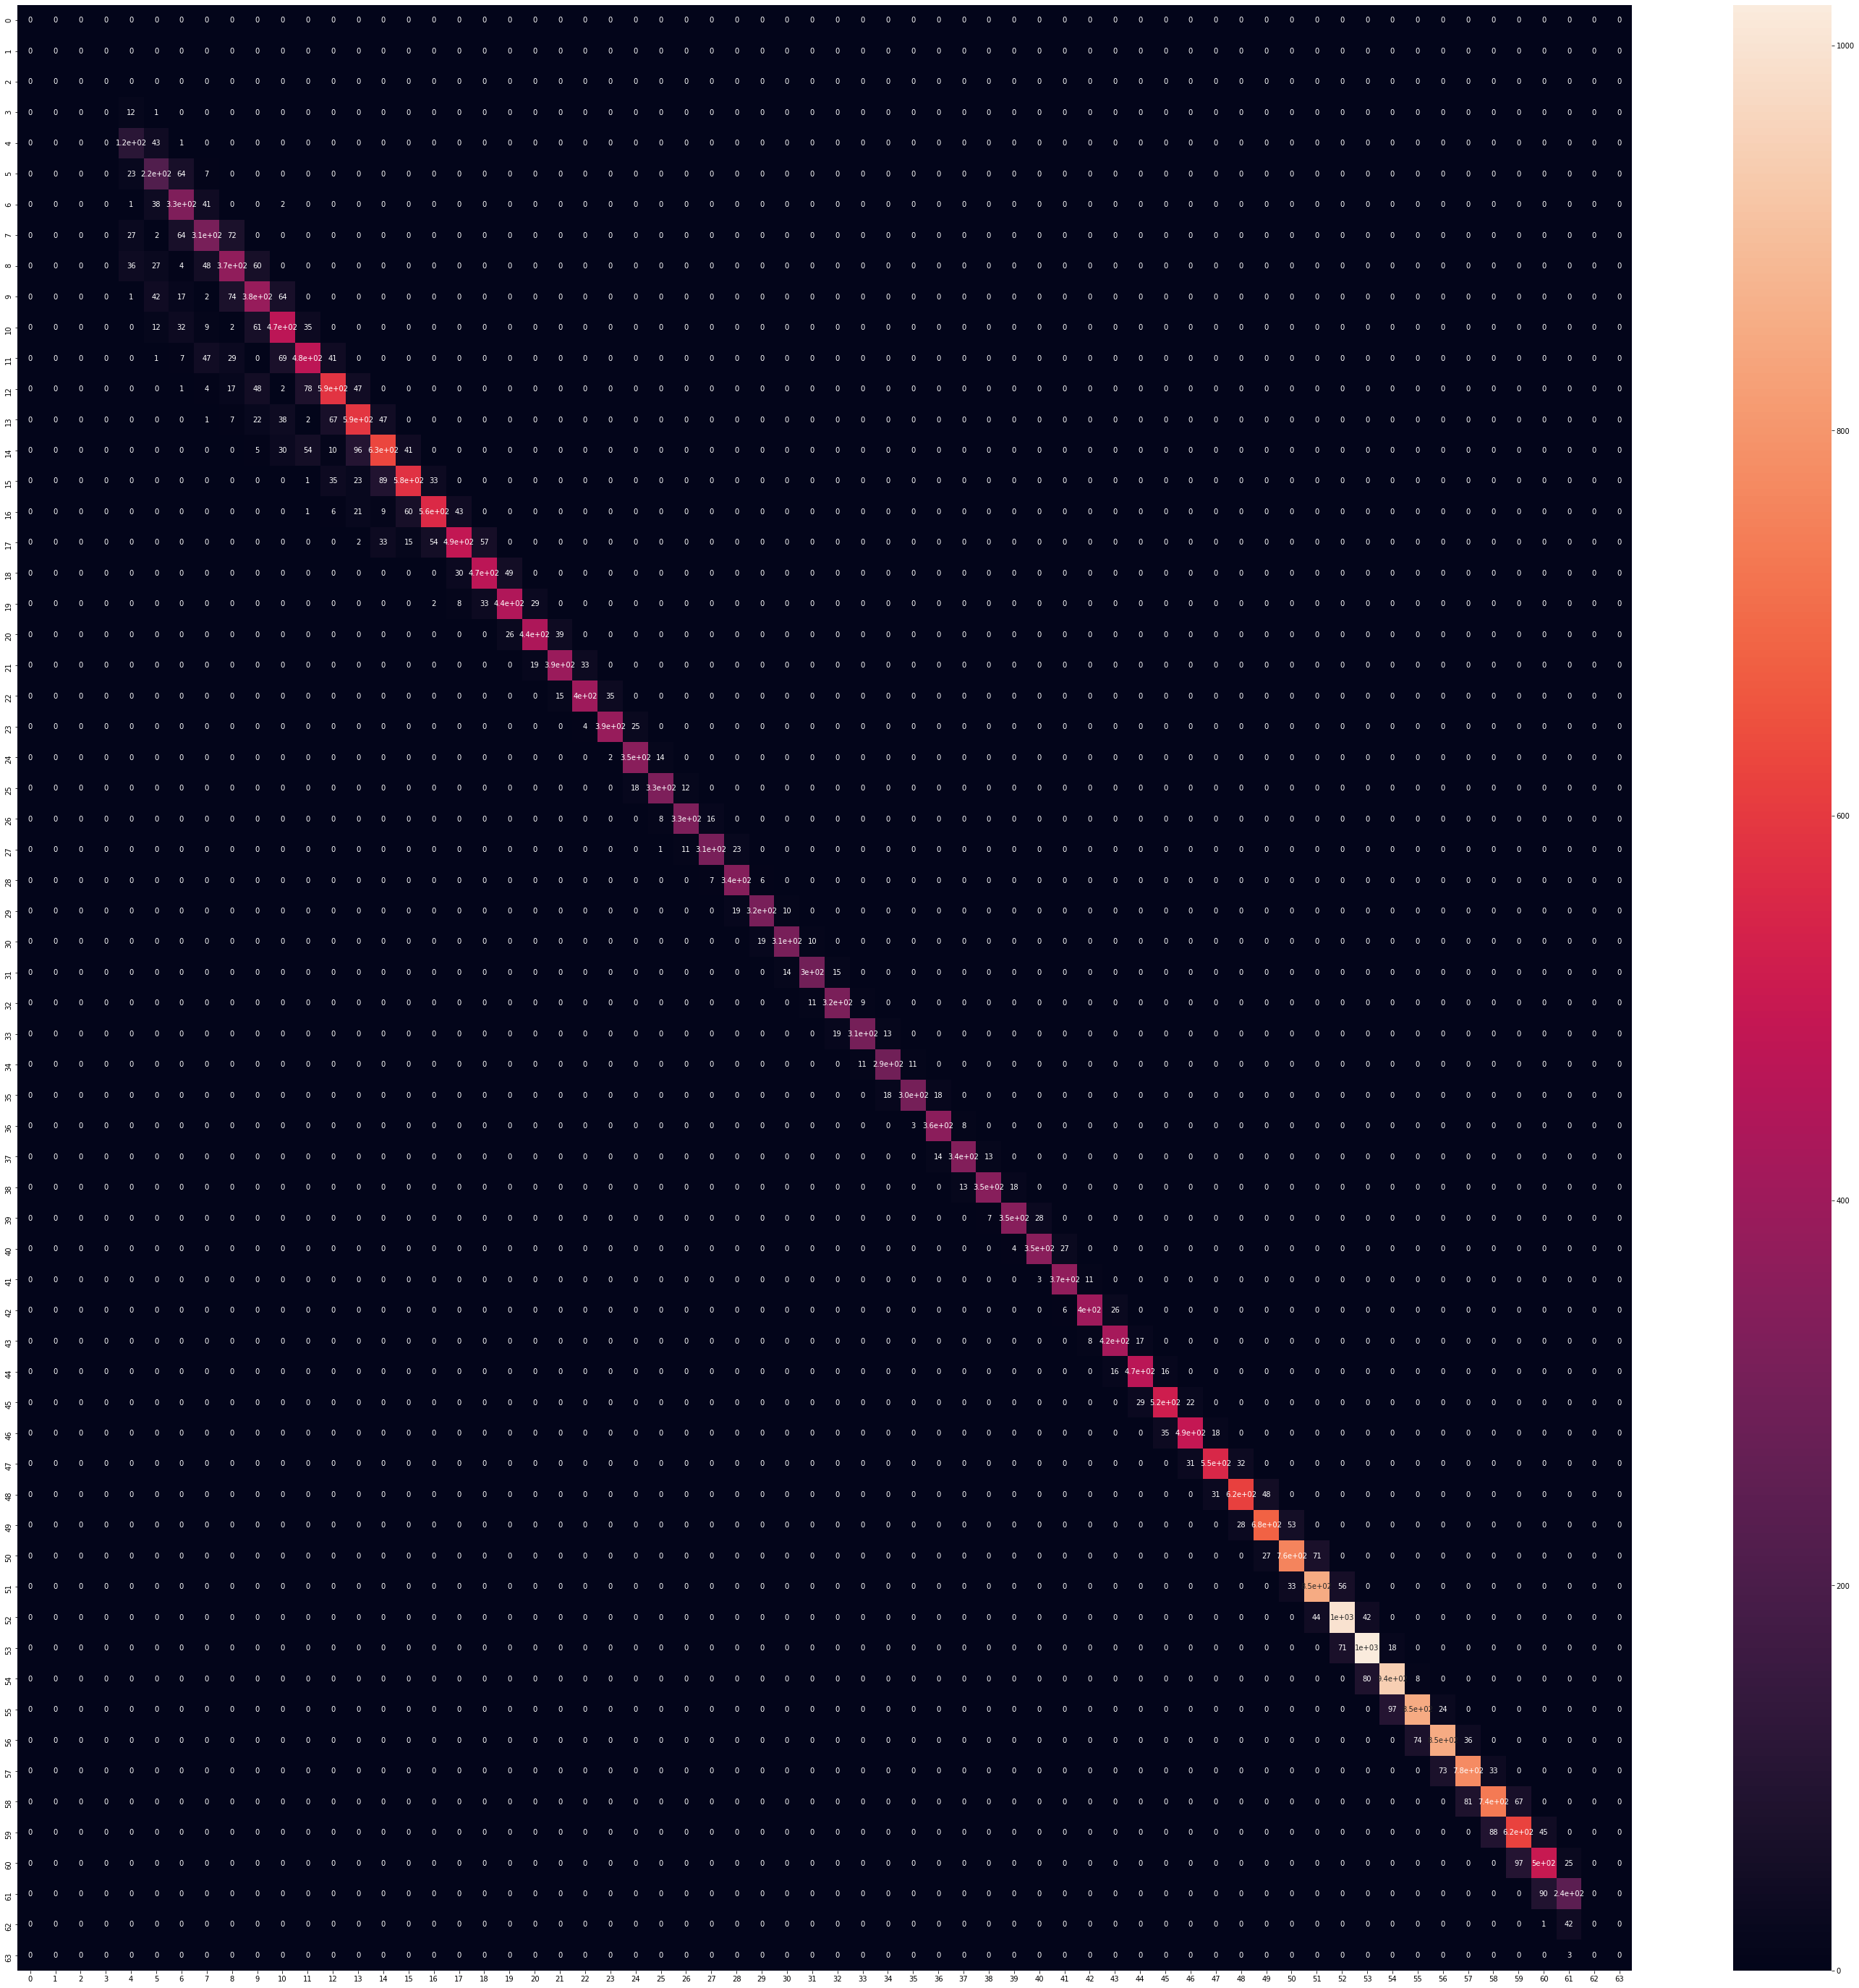

In [19]:
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser, Namespace
import wandb
from pytorch_lightning.callbacks import ModelCheckpoint
from dotenv import load_dotenv

PROJECT_ROOT = os.path.dirname(os.path.abspath('.'))
load_dotenv(dotenv_path=os.path.join(PROJECT_ROOT, '.env'))

!wandb login 12f84ed3682e47836a736950196a7349421a6cbb
#!wandb login --relogin
#12f84ed3682e47836a736950196a7349421a6cbb
# import pdb

parser = ArgumentParser(add_help=False)
parser.add_argument('-wandb_run_name',
                '--wandb_run_name',
                help='Name of Wandb Run',
                default='run',
                type=str)
parser.add_argument('-wandb_project_name',
                    '--wandb_project_name',
                    help='Wandb Project Name',
                    default='deep_dream',
                    type=str)
parser.add_argument('-model_ckpt_path',
                    '--model_ckpt_path',
                    help='Model Checkpoint Path',
                    default='./ckpts/model.ckpt',
                    type=str)
parser.add_argument('-wandb_log_num_iter',
                    '--wandb_log_num_iter',
                    help='After how many batches, we will log in training loop',
                    default=1,
                    type=int)
parser.add_argument('-init_ckpt',
                    '--init_ckpt',
                    help='Initial Ckpt',
                    default=None,
                    type=str)

def main(args):
    """Main function that will perform all the training"""
    # init module
    model = BeamClassifier(args)

    # Using Wandblogger so that we can log our results to wandb
    wandb.init(name=args.wandb_run_name,
               project=args.wandb_project_name,
               config=vars(args))
        
    wandb.watch(model)

    # most basic trainer, uses good defaults
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='./ckpts',
        filename='{epoch:02d}-{val_loss:.2f}'
    )
    trainer = Trainer(logger=[], 
                      gpus=args.gpus, 
                      max_epochs=args.max_nb_epochs, 
                      resume_from_checkpoint=args.init_ckpt)
#     pdb.set_trace()
    trainer.fit(model)
    trainer.test()
    
    ckpt_path = os.path.join('./ckpt', f"{args.wandb_project_name}", f"{args.wandb_run_name}.ckpt")
    ckpt_base_path = os.path.dirname(ckpt_path)
    trainer.save_checkpoint(ckpt_path)
    wandb.save(ckpt_path)

    return model

if __name__ == '__main__':

    # auto add args from trainer
    parser = Trainer.add_argparse_args(parser)

    # give the module a chance to add own params
    # good practice to define LightningModule speficic params in the module
    parser = BeamClassifier.add_model_specific_args(parser)

    # parse params
    args = parser.parse_args(args_str)

    seed_everything(123)

    model = main(args)